In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import scipy.stats as stats

# Travail à faire
Vous êtes missionné sur le projet de nettoyage et exploration des données en interne, afin de déterminer la faisabilité de cette idée d’application de Santé publique France.

# 1. Présentation générale du jeu de données

In [3]:
produit = pd.read_csv('prod.csv', sep='\t', low_memory=False)
produit.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- La dimension du dataframe

In [4]:
produit.shape

(320772, 162)

- La méthode `info` nous donne des indications globales

In [5]:
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


### Aperçu des valeurs manquantes

- Le nombre de valeur manquante par colonne

In [6]:
produit.isna().sum()

code                           23
url                            23
creator                         2
created_t                       3
created_datetime                9
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 162, dtype: int64

### Sélection des features sur lesquels nous allons travailler, la plupart de ces variables ont moins de moins 50% de valeurs manquantes.

In [7]:
echan = ['product_name','fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g','nutrition_grade_fr','pnns_groups_1']
echan0 = produit[echan]

### Aperçu du nombre des valeurs manquantes

In [8]:
echan0.isna().sum()

product_name           17762
fiber_100g            119886
proteins_100g          60850
vitamin-a_100g        183218
vitamin-c_100g        179905
fat_100g               76881
carbohydrates_100g     77184
sugars_100g            75801
sodium_100g            65309
nutrition_grade_fr     99562
pnns_groups_1         229259
dtype: int64

### Le pourcentage de valeurs manquantes dans chaque colonne.

In [9]:
miss = echan0.isna().mean()*100
miss

product_name           5.537266
fiber_100g            37.374210
proteins_100g         18.969860
vitamin-a_100g        57.117828
vitamin-c_100g        56.085007
fat_100g              23.967491
carbohydrates_100g    24.061951
sugars_100g           23.630803
sodium_100g           20.359944
nutrition_grade_fr    31.038245
pnns_groups_1         71.471014
dtype: float64

<AxesSubplot:>

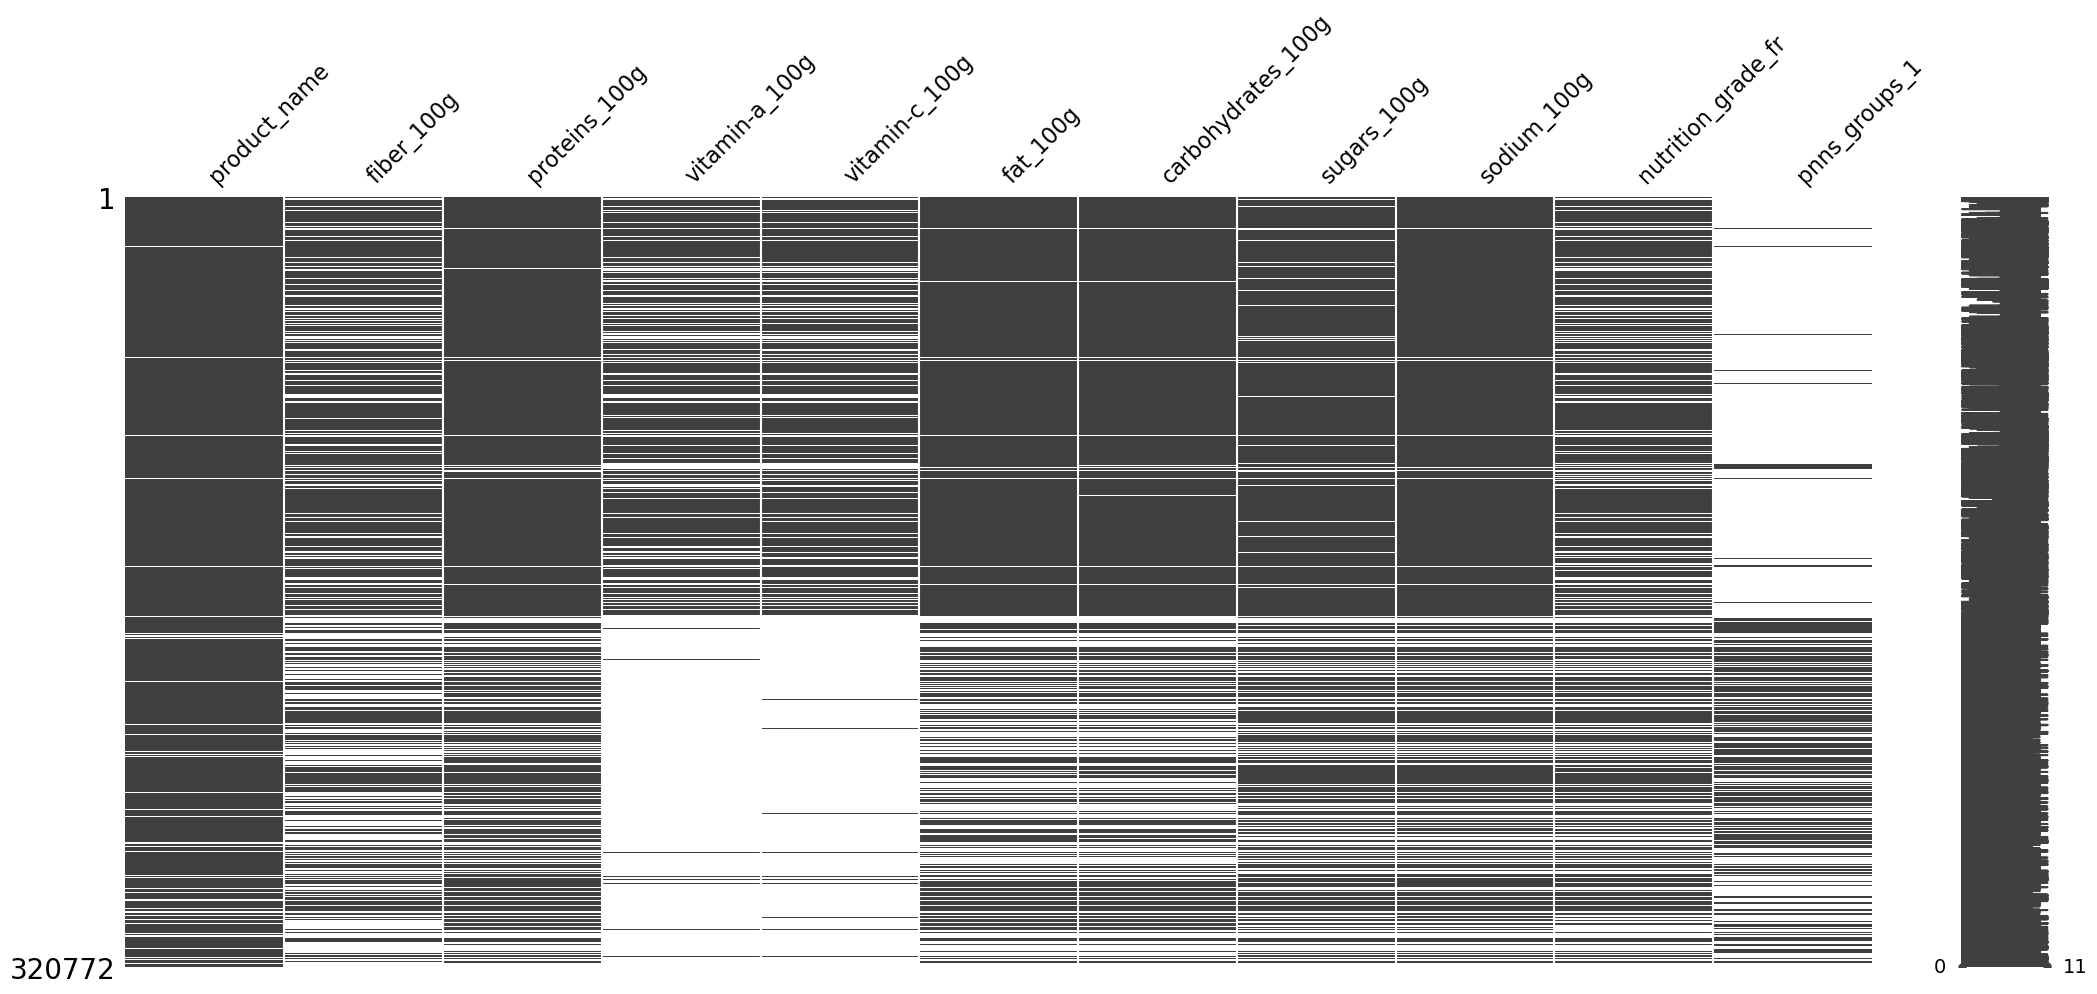

In [10]:
msno.matrix(echan0)

# 2. Nettoyage des données

In [11]:
echan0.shape

(320772, 11)

## 2.1 Traitement des valeurs manquantes

#### - Suppression des lignes dont le nom produit n'est pas renseigné et autres nom de produit non conforme

In [12]:
echan0 = echan0.dropna(subset=['product_name'])

In [13]:
echan0 = echan0.dropna(subset=['pnns_groups_1'])

In [14]:
echan0 = echan0.dropna(subset=['nutrition_grade_fr'])

In [15]:
echan0.drop(echan0[echan0['product_name'] == ' '].index, inplace = True)

In [16]:
 echan0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
106,Lion Peanut x2,2.500,2.500,NaN,NaN,20.00,70.00,57.500,0.038000,e,unknown
174,Salade Cesar,2.000,22.000,0.000000,0.000000,12.00,23.00,0.000,0.850000,c,Fruits and vegetables
180,Chaussons tressés aux pommes,2.000,3.330,0.000000,0.001600,10.70,38.70,24.700,0.255000,c,Sugary snacks
181,Pain Burger Artisan,2.220,10.000,0.000000,0.000000,1.11,53.30,1.110,0.600000,b,unknown
185,Quiche Lorraine,0.357,5.360,0.000011,0.000429,6.79,7.86,0.714,0.196000,b,Composite foods
...,...,...,...,...,...,...,...,...,...,...,...
320693,Santa Cruz Chilli & Lime Dressing,0.600,0.300,NaN,NaN,6.90,23.10,16.700,0.213000,c,Fat and sauces
320702,Fisherman's Friend Miel-Citron,1.470,0.004,NaN,NaN,1.30,95.31,0.100,0.000394,b,Sugary snacks
320734,Nature cheddar and red onion crisps,5.600,7.800,NaN,NaN,NaN,NaN,1.800,0.531496,c,Salty snacks
320751,Tartines craquantes bio au sarrasin,5.900,13.000,NaN,NaN,2.80,74.80,2.600,0.267717,a,Cereals and potatoes


In [17]:
echan0.isna().sum()

product_name              0
fiber_100g            21738
proteins_100g           185
vitamin-a_100g        59172
vitamin-c_100g        58451
fat_100g               3505
carbohydrates_100g     3564
sugars_100g             185
sodium_100g             185
nutrition_grade_fr        0
pnns_groups_1             0
dtype: int64

#### - Filtrage sur les differents 'Features' fibre, proteins_100g, vitamin-c_100g, sodium_100g, carbohydrates_100g, etc. 

In [18]:
echan0 = echan0.drop(echan0[(echan0['fiber_100g'] < 0) & (echan0['fiber_100g'] < 100 )].index)

In [19]:
echan0 = echan0.drop(echan0[(echan0['proteins_100g'] < 0) & (echan0['proteins_100g'] < 100 )].index)

In [20]:
echan0 = echan0.drop(echan0[(echan0['vitamin-a_100g'] < 0) & (echan0['vitamin-a_100g'] < 100 )].index)

In [21]:
echan0 = echan0.drop(echan0[(echan0['vitamin-c_100g'] < 0) & (echan0['vitamin-c_100g'] < 100 )].index)

In [22]:
echan0 = echan0.drop(echan0[(echan0['sodium_100g'] < 0) & (echan0['sodium_100g'] < 100 )].index)

In [23]:
echan0 = echan0.drop(echan0[(echan0['carbohydrates_100g'] < 0) & (echan0['carbohydrates_100g'] < 100)].index)

In [24]:
echan0 = echan0.drop(echan0[(echan0['fat_100g'] < 0) & (echan0['fat_100g'] < 100)].index)

In [25]:
echan0 = echan0.drop(echan0[(echan0['sugars_100g'] < 0) & (echan0['sugars_100g'] < 100)].index)

In [26]:
echan0 

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
106,Lion Peanut x2,2.500,2.500,NaN,NaN,20.00,70.00,57.500,0.038000,e,unknown
174,Salade Cesar,2.000,22.000,0.000000,0.000000,12.00,23.00,0.000,0.850000,c,Fruits and vegetables
180,Chaussons tressés aux pommes,2.000,3.330,0.000000,0.001600,10.70,38.70,24.700,0.255000,c,Sugary snacks
181,Pain Burger Artisan,2.220,10.000,0.000000,0.000000,1.11,53.30,1.110,0.600000,b,unknown
185,Quiche Lorraine,0.357,5.360,0.000011,0.000429,6.79,7.86,0.714,0.196000,b,Composite foods
...,...,...,...,...,...,...,...,...,...,...,...
320693,Santa Cruz Chilli & Lime Dressing,0.600,0.300,NaN,NaN,6.90,23.10,16.700,0.213000,c,Fat and sauces
320702,Fisherman's Friend Miel-Citron,1.470,0.004,NaN,NaN,1.30,95.31,0.100,0.000394,b,Sugary snacks
320734,Nature cheddar and red onion crisps,5.600,7.800,NaN,NaN,NaN,NaN,1.800,0.531496,c,Salty snacks
320751,Tartines craquantes bio au sarrasin,5.900,13.000,NaN,NaN,2.80,74.80,2.600,0.267717,a,Cereals and potatoes


#### - Remplissage des valeurs manquantes par median mean ou 0 en fonction des features 

In [27]:
echan0.loc[echan0['fiber_100g'].isna(), 'fiber_100g'] = 0

In [28]:
echan0.loc[echan0['proteins_100g'].isna(), 'proteins_100g'] = echan0['proteins_100g'].mean()

In [29]:
echan0.loc[echan0['fat_100g'].isna(), 'fat_100g'] = echan0['fat_100g'].mean()  

In [30]:
echan0.loc[echan0['carbohydrates_100g'].isna(), 'carbohydrates_100g'] = echan0['carbohydrates_100g'].median() 

In [31]:
echan0.loc[echan0['sugars_100g'].isna(), 'sugars_100g'] = echan0['sugars_100g'].median()  

In [32]:
echan0.loc[echan0['sodium_100g'].isna(), 'sodium_100g'] = echan0['sodium_100g'].median()  

In [33]:
echan0.loc[echan0['vitamin-c_100g'].isna(), 'vitamin-c_100g'] = echan0['vitamin-c_100g'].median()
echan0['vitamin-c_100g'] =echan0['vitamin-c_100g']*10

In [34]:
echan0.loc[echan0['vitamin-a_100g'].isna(), 'vitamin-a_100g'] = echan0['vitamin-a_100g'].median()
echan0['vitamin-a_100g'] = echan0['vitamin-a_100g']*10

In [35]:
echan0 = echan0.drop(echan0[(echan0['vitamin-a_100g'] < 0) & (echan0['vitamin-a_100g'] < 100 )].index)

In [36]:
echan0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
106,Lion Peanut x2,2.500,2.500,0.000529,0.10000,20.000000,70.00,57.500,0.038000,e,unknown
174,Salade Cesar,2.000,22.000,0.000000,0.00000,12.000000,23.00,0.000,0.850000,c,Fruits and vegetables
180,Chaussons tressés aux pommes,2.000,3.330,0.000000,0.01600,10.700000,38.70,24.700,0.255000,c,Sugary snacks
181,Pain Burger Artisan,2.220,10.000,0.000000,0.00000,1.110000,53.30,1.110,0.600000,b,unknown
185,Quiche Lorraine,0.357,5.360,0.000107,0.00429,6.790000,7.86,0.714,0.196000,b,Composite foods
...,...,...,...,...,...,...,...,...,...,...,...
320693,Santa Cruz Chilli & Lime Dressing,0.600,0.300,0.000529,0.10000,6.900000,23.10,16.700,0.213000,c,Fat and sauces
320702,Fisherman's Friend Miel-Citron,1.470,0.004,0.000529,0.10000,1.300000,95.31,0.100,0.000394,b,Sugary snacks
320734,Nature cheddar and red onion crisps,5.600,7.800,0.000529,0.10000,13.499853,15.00,1.800,0.531496,c,Salty snacks
320751,Tartines craquantes bio au sarrasin,5.900,13.000,0.000529,0.10000,2.800000,74.80,2.600,0.267717,a,Cereals and potatoes


#### - Le pourcentage de données manquantes

In [37]:
miss = echan0.isna().mean()*100
miss

product_name          0.0
fiber_100g            0.0
proteins_100g         0.0
vitamin-a_100g        0.0
vitamin-c_100g        0.0
fat_100g              0.0
carbohydrates_100g    0.0
sugars_100g           0.0
sodium_100g           0.0
nutrition_grade_fr    0.0
pnns_groups_1         0.0
dtype: float64

### 2.2  Recherche et suppression des duplicatas

In [38]:
dupli = echan0[echan0.duplicated(keep=False)]
dupli

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
564,Pur Soup' Velouté de légumes,0.8,0.800000,0.001200,0.1,2.100000,5.3,2.4,0.295276,b,Fruits and vegetables
595,Yellow Mustard,0.0,7.486546,0.000529,0.1,13.499853,15.0,4.1,0.200000,b,Fat and sauces
628,British plain flour,3.1,9.400000,0.000529,0.1,1.300000,77.7,1.5,0.003940,a,Cereals and potatoes
884,British plain flour,3.1,9.400000,0.000529,0.1,1.300000,77.7,1.5,0.003940,a,Cereals and potatoes
1345,Nutella,2.7,5.410000,0.000000,0.0,32.400000,56.8,56.8,0.040500,e,unknown
...,...,...,...,...,...,...,...,...,...,...,...
318503,Kinder Schoko-Bons,0.0,8.300000,0.000529,0.1,36.600000,52.5,52.2,0.110236,e,Sugary snacks
319170,Vegemite,7.8,25.400000,0.000529,0.1,1.000000,19.9,2.2,3.450000,c,unknown
319927,Speisequark Magerstufe,0.0,12.000000,0.000529,0.1,0.200000,4.1,4.1,0.039370,a,Milk and dairy products
320299,Vegemite,7.8,25.400000,0.000529,0.1,1.000000,19.9,2.2,3.450000,c,unknown


In [39]:
echan0 = echan0.drop_duplicates(keep='first')

#### Verification après nettoyage

In [40]:
echan0.duplicated().sum()

0

## Echantillonnage avec la fonction *sample()*

In [41]:
jeu0 = echan0.sample(frac=0.9)
jeu0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
307146,Tableta de chocolate negro edulcorado con este...,18.000,6.50,0.000529,0.1,37.00,32.5,0.5,0.027559,c,Sugary snacks
270763,Pure Soya Spread,0.000,0.50,0.008000,0.1,54.00,1.0,0.5,0.295276,e,unknown
269950,Jelly babies,0.500,4.60,0.000529,0.1,0.50,79.6,69.9,0.015748,d,Sugary snacks
313835,Cookie Dough Ice Cream,0.000,4.00,0.000529,0.1,15.00,29.0,25.0,0.055118,d,unknown
183037,Speisequark 40% Fett i. Tr.,0.000,9.00,0.000529,0.1,10.30,3.2,3.2,0.039370,b,Milk and dairy products
...,...,...,...,...,...,...,...,...,...,...,...
256013,Weiße Riesenbohnen,20.000,18.00,0.000529,0.1,2.30,41.0,6.0,0.003937,a,Cereals and potatoes
32081,Light & Fit Greek Crunch Coconut Chocolate Bliss,0.709,8.51,0.000529,0.1,2.13,11.3,7.8,0.053200,a,Milk and dairy products
189292,Taillefine Plus Cerise (0 % MG),0.000,8.20,0.000529,0.1,0.10,6.9,6.3,0.074803,a,Milk and dairy products
63710,Weetabix original,10.000,11.50,0.000529,0.1,2.00,68.6,4.4,0.255906,a,Cereals and potatoes


In [42]:
jeu0_C=jeu0

In [43]:
jeu0.duplicated().sum()

0

In [44]:
jeu0.dtypes

product_name           object
fiber_100g            float64
proteins_100g         float64
vitamin-a_100g        float64
vitamin-c_100g        float64
fat_100g              float64
carbohydrates_100g    float64
sugars_100g           float64
sodium_100g           float64
nutrition_grade_fr     object
pnns_groups_1          object
dtype: object

# 3. Analyse exploratoire

## 3.1 Analyses univariées

### 3.1.1 Variables quantitatives

In [45]:
jeu0.describe()

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
count,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000
mean,1.810986,7.487182,0.000630,0.108622,13.353429,27.257215,13.028389,0.412229
std,3.671427,7.424331,0.007206,0.817937,16.232215,26.585803,18.506649,1.681585
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.800000,0.000529,0.100000,1.500000,4.800000,1.000000,0.030000
50%,0.200000,5.900000,0.000529,0.100000,8.000000,15.000000,4.100000,0.200000
75%,2.400000,10.100000,0.000529,0.100000,20.000000,52.000000,16.600000,0.472441
max,178.000000,100.000000,1.200000,180.000000,380.000000,190.000000,134.000000,117.165354


#### Etude statistique du features *proteins_100g*

In [46]:
jeu0['proteins_100g'].quantile([ 0.25 , 0.5 , 0.75 ])  

0.25     1.8
0.50     5.9
0.75    10.1
Name: proteins_100g, dtype: float64

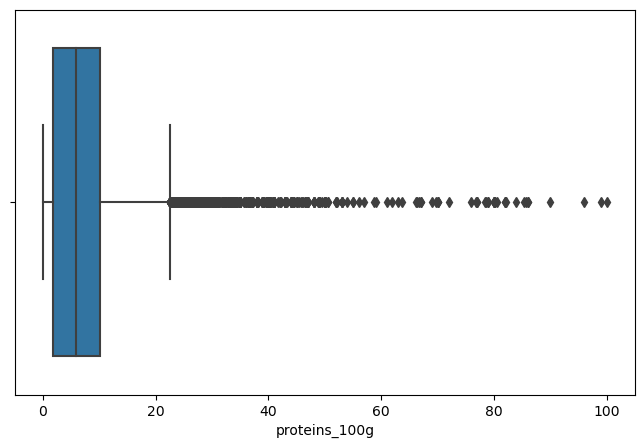

In [47]:
plt.figure(figsize=(8,5))
sns.boxplot(x=jeu0['proteins_100g'])
plt.show()

Elle permet de représenter schématiquement une distribution, en incluant sa dispersion

### 3.1.2 Variables qualitatives 

#### La distribution entre deux variables qualitatives categorielles

In [48]:
jeu0.describe(include="object")

,product_name,nutrition_grade_fr,pnns_groups_1
count,53690,53690,53690
unique,46158,5,14
top,Jus d'orange,d,unknown
freq,35,14623,9566


####  La distribution par modalité de la variable *pnns_groups* catégorie de Food

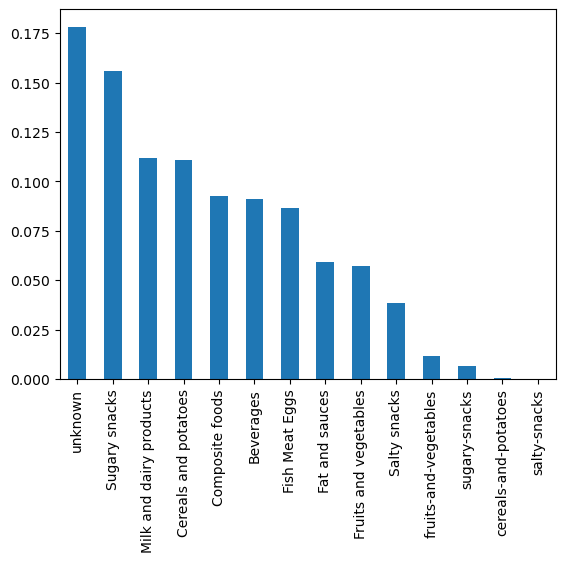

In [49]:
jeu0["pnns_groups_1"].value_counts(normalize=True).plot(kind='bar')# Diagramme en tuyaux d'orgues
plt.xlabel('\n', fontsize=10, color='red')
plt.show()

#### La repartition des produits par rapport à la variable categorielle *nutrigrade*

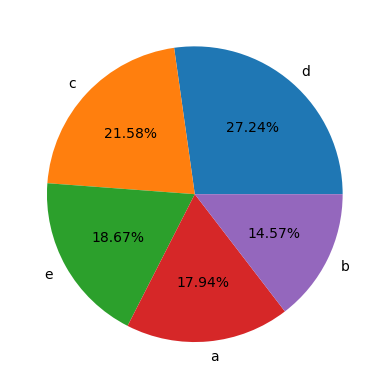

In [50]:
rep = (jeu0['nutrition_grade_fr'].value_counts())/len(jeu0)
rep
plt.pie(rep,labels=rep.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

#### Le nombre de produit par typeProduits

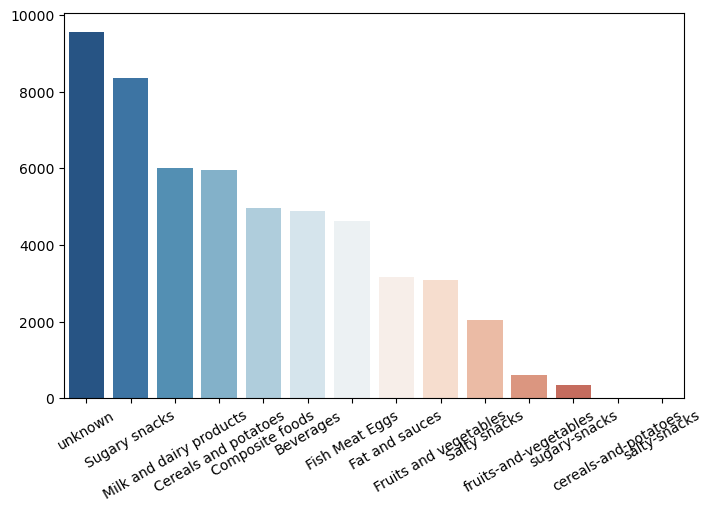

In [51]:
NbrTypeProd = jeu0['pnns_groups_1'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=NbrTypeProd.index, y=NbrTypeProd.values, palette="RdBu_r") # Diagramme en bâtons(barres)
plt.xticks(rotation= 30);


## 3.2 Analyses bivariées

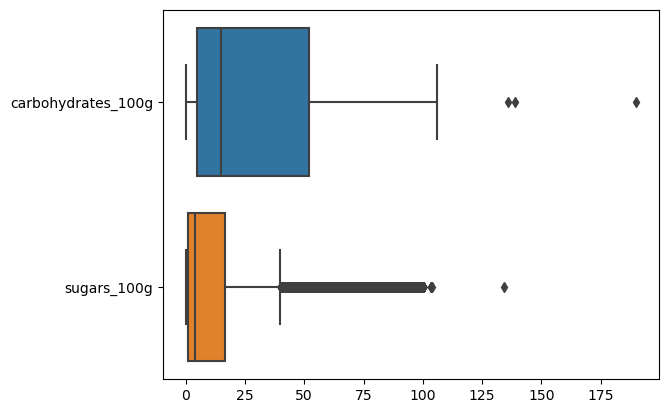

In [52]:
sns.boxplot(data=jeu0[["carbohydrates_100g", "sugars_100g"]], orient="h")
plt.show()

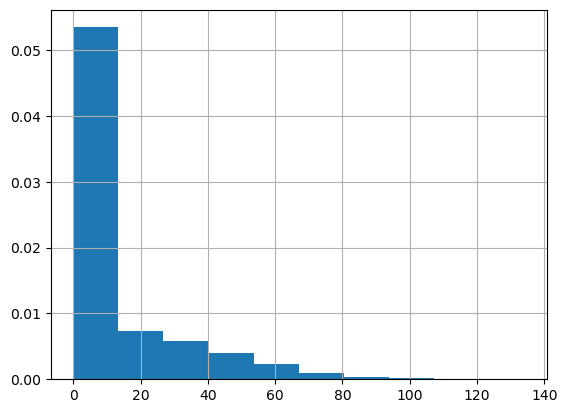

In [53]:
jeu0["sugars_100g"].hist(density=True)
plt.show()

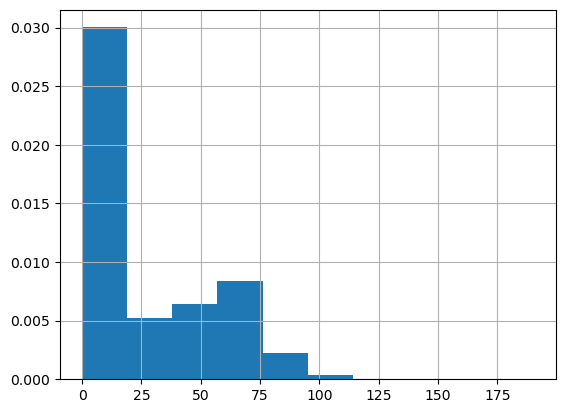

In [54]:
jeu0["carbohydrates_100g"].hist(density=True)
plt.show()

In [55]:
ess = jeu0.groupby('nutrition_grade_fr')['proteins_100g'].mean().reset_index()
ess

,nutrition_grade_fr,proteins_100g
0,a,7.515558
1,b,6.011203
2,c,6.775200
3,d,9.151457
4,e,7.006843


In [56]:
es = jeu0.groupby('nutrition_grade_fr')['sugars_100g'].mean().reset_index()
es

,nutrition_grade_fr,sugars_100g
0,a,3.962858
1,b,4.826395
2,c,9.742404
3,d,16.821091
4,e,26.403116


In [57]:
gra = jeu0.groupby('nutrition_grade_fr')['fat_100g'].mean().reset_index()
gra

,nutrition_grade_fr,fat_100g
0,a,3.282045
1,b,4.858339
2,c,9.340630
3,d,19.327435
4,e,25.581698


#### - Le pourcentage de proteine en moyenne contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

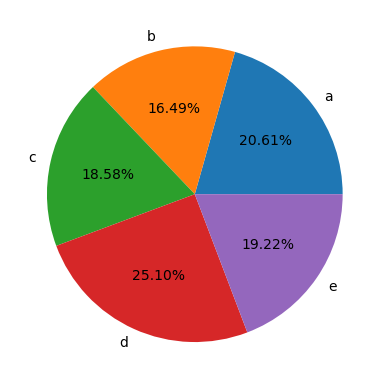

In [58]:
plt.pie(x=ess['proteins_100g'], labels=ess['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

#### - La moyenne en pourcentage de sucre contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

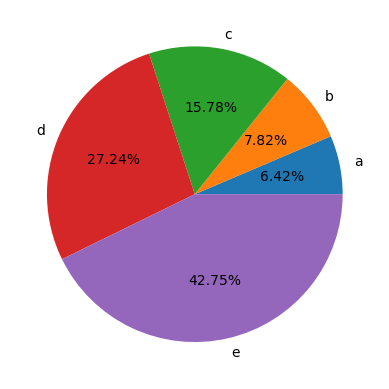

In [59]:
plt.pie(x=es['sugars_100g'], labels=es['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

#### - Le pourcentage de graisse en moyenne contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

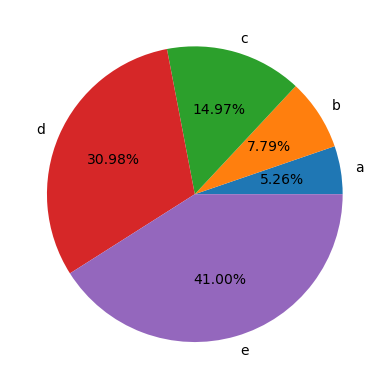

In [60]:
plt.pie(x=gra['fat_100g'], labels=gra['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

- Le volume de sucre en moyenne contenu dans les produits classés par catégorie nutrigrade

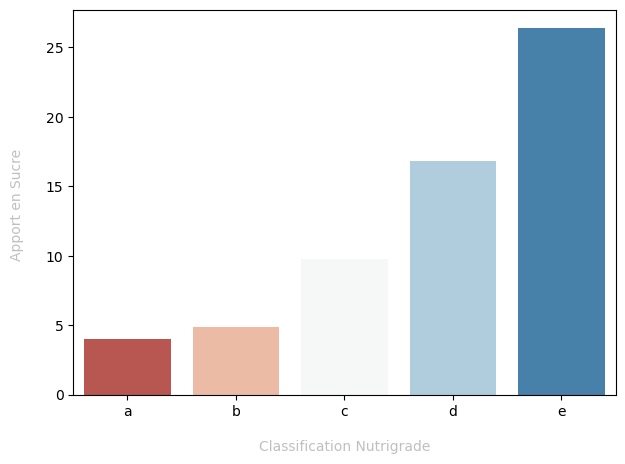

In [61]:
plt.figure(figsize=(7,5))
sns.barplot(x=es['nutrition_grade_fr'], y=es['sugars_100g'], palette="RdBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='silver')
plt.ylabel("Apport en Sucre \n", fontsize=10, color='silver')
plt.show()

**La quantité de graisse en moyenne contenu dans les produits classés par catégorie nutrigrade**

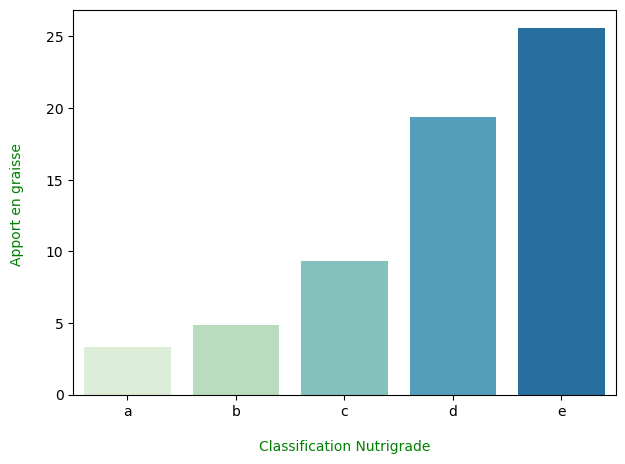

In [62]:
plt.figure(figsize=(7,5))
sns.barplot(x=gra['nutrition_grade_fr'], y=gra['fat_100g'], palette="GnBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='green')
plt.ylabel("Apport en graisse \n", fontsize=10, color='green')
plt.show()

**La quantité de proteine en moyenne contenu dans les produits classés par catégorie nutrigrade**

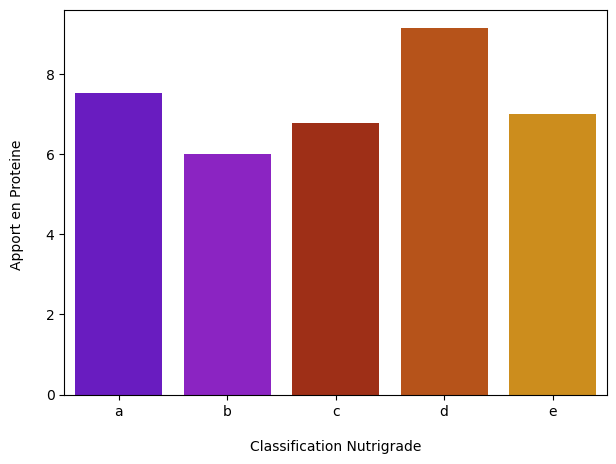

In [63]:
plt.figure(figsize=(7,5))
sns.barplot(x=ess['nutrition_grade_fr'], y=ess['proteins_100g'], palette="gnuplot")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='black')
plt.ylabel("Apport en Proteine \n", fontsize=10, color='black')
plt.show()

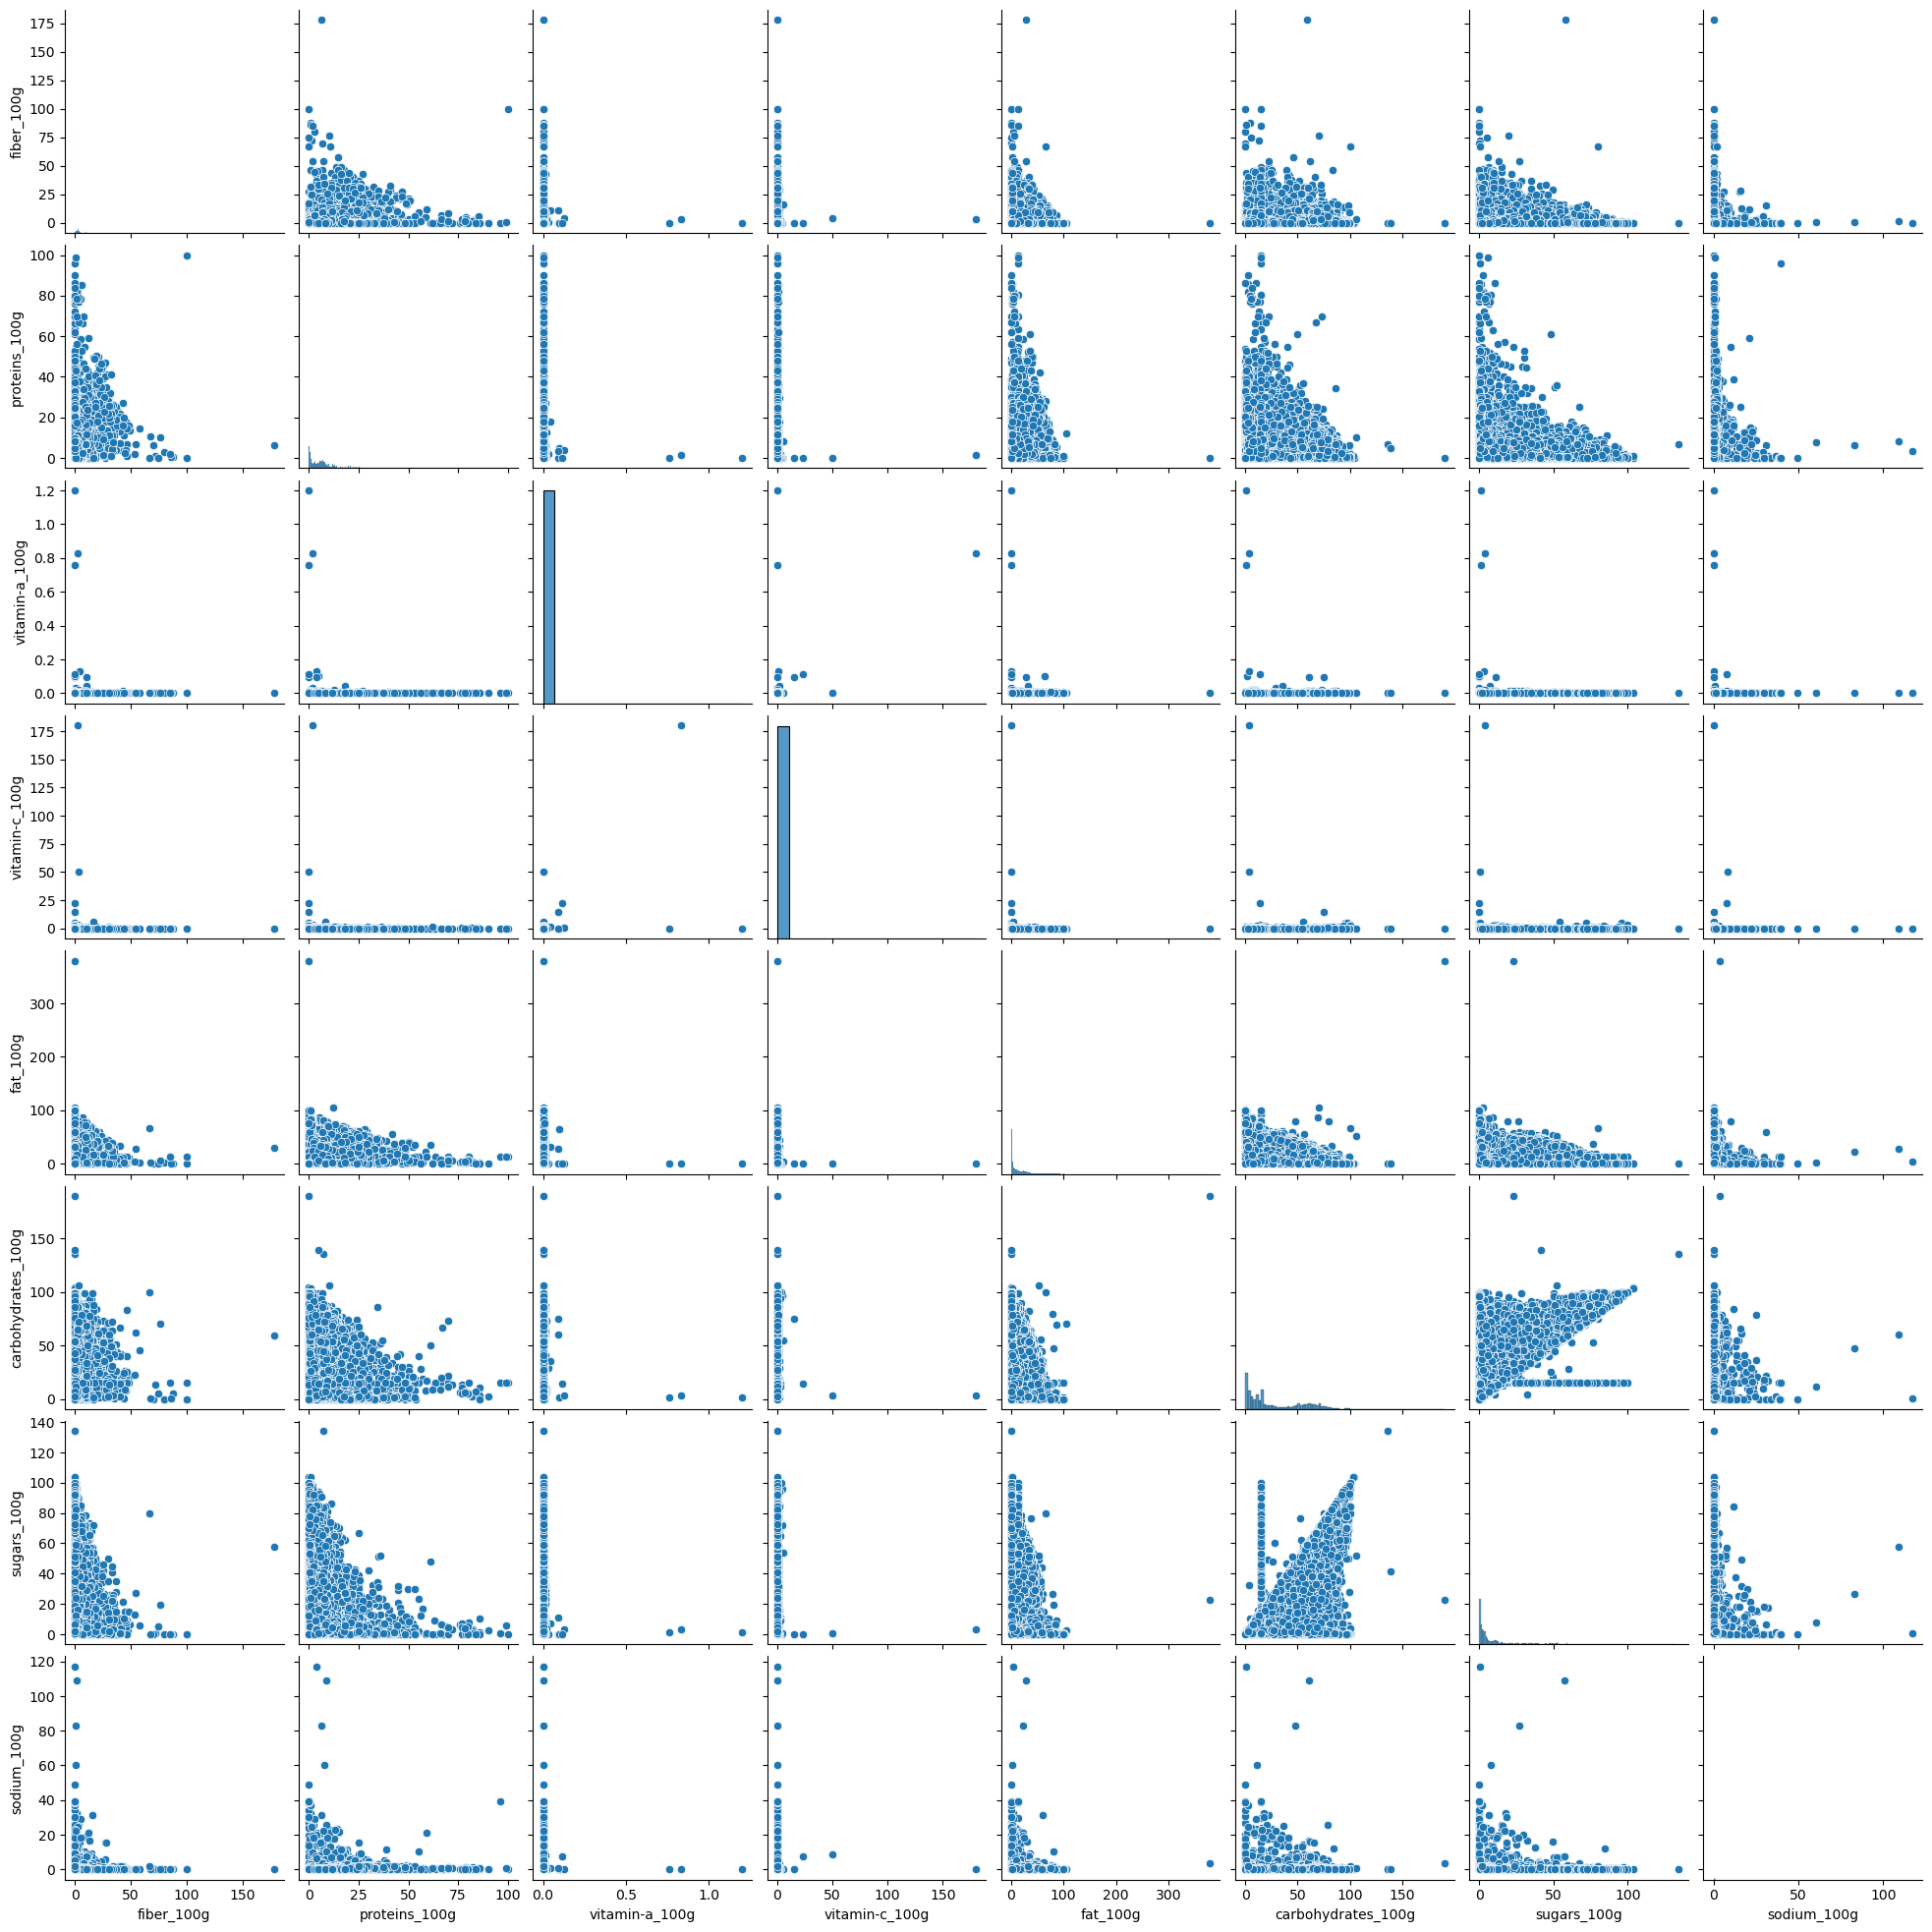

In [64]:
sns.pairplot(jeu0)

<AxesSubplot:>

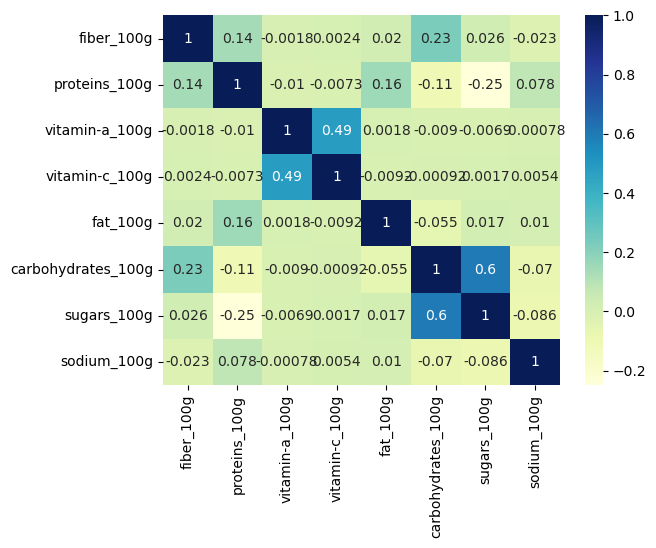

In [65]:
corr_matrix = jeu0.corr()
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")

Il y a correlation entre les variables carbohydrates_100g et sugars_100g (0.61)	

In [66]:
jeuD = jeu0_C.drop(columns =['fiber_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'sodium_100g','pnns_groups_1'])

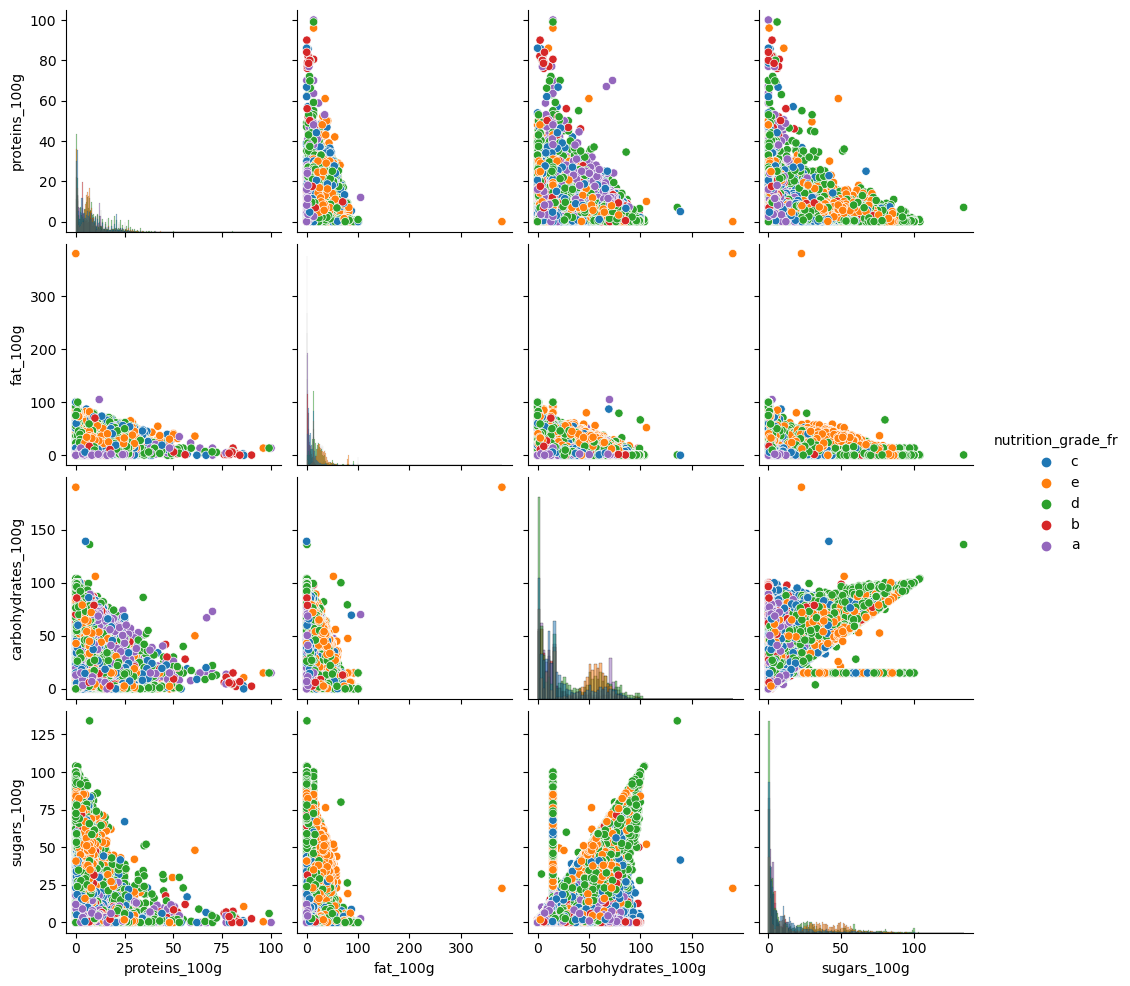

In [68]:
sns.pairplot(jeuD, hue ="nutrition_grade_fr", diag_kind="hist")

###  *Analyse Anova*

#### Test Anova sur les features *carbohydrates_100g* et *nutrition_grade*

In [69]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()


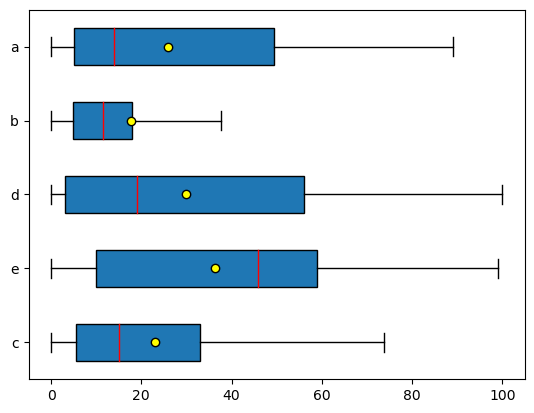

In [70]:
modalites = sous_echantillon[X].unique()
groupes = []
for i in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==i][Y])

# Propriétés graphiques   
medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'yellow'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [71]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.049592149238680334

eta_squared = 0.04959 est plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le carbohydrates. 

#### Test Anova sur les features *fiber* et *nutrition_grade*

In [72]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()

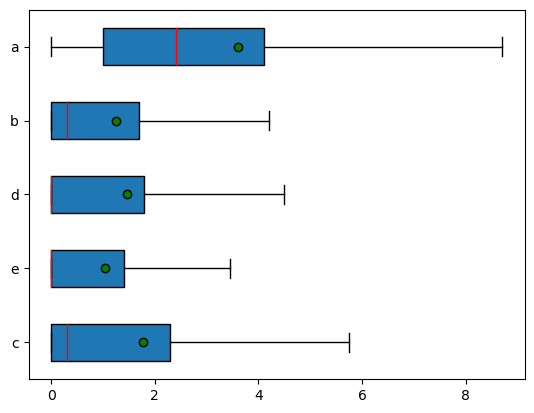

In [73]:
modalites = sous_echantillon[X].unique()
groupes = []
for j in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==j][Y])  
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'green'}
medianprops = {'color':"red"}
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [74]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.06149191617506318

eta_squared = 0.0614 qui est beaucoup plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le fiber

##### Conclusion:  Le test ANOVA (l'homogénéité de la moyenne de la variable quantitative étudiée sur les différentes valeurs de la variable qualitative). Dans notre cas l'analyse de la variance  aboutit à un résultat proche de zéro donc l'hypothèse nulle est retenue : La variable qualitative n'influe pas sur la variable quantitative

## 3.3 Analyses multivariées (ACP)

#### Preparation des données

In [76]:
jeu0 = jeu0.set_index('product_name', drop=True)
jeu0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
product_name,,,,,,,,,,
Tableta de chocolate negro edulcorado con estevia 60% cacao,18.000,6.50,0.000529,0.1,37.00,32.5,0.5,0.027559,c,Sugary snacks
Pure Soya Spread,0.000,0.50,0.008000,0.1,54.00,1.0,0.5,0.295276,e,unknown
Jelly babies,0.500,4.60,0.000529,0.1,0.50,79.6,69.9,0.015748,d,Sugary snacks
Cookie Dough Ice Cream,0.000,4.00,0.000529,0.1,15.00,29.0,25.0,0.055118,d,unknown
Speisequark 40% Fett i. Tr.,0.000,9.00,0.000529,0.1,10.30,3.2,3.2,0.039370,b,Milk and dairy products
...,...,...,...,...,...,...,...,...,...,...
Weiße Riesenbohnen,20.000,18.00,0.000529,0.1,2.30,41.0,6.0,0.003937,a,Cereals and potatoes
Light & Fit Greek Crunch Coconut Chocolate Bliss,0.709,8.51,0.000529,0.1,2.13,11.3,7.8,0.053200,a,Milk and dairy products
Taillefine Plus Cerise (0 % MG),0.000,8.20,0.000529,0.1,0.10,6.9,6.3,0.074803,a,Milk and dairy products


In [78]:
jeu0_C=jeu0


In [79]:
sell = ['fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g']
jeu0 = jeu0[sell]

In [80]:
jeu0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
product_name,,,,,,,,
Tableta de chocolate negro edulcorado con estevia 60% cacao,18.000,6.50,0.000529,0.1,37.00,32.5,0.5,0.027559
Pure Soya Spread,0.000,0.50,0.008000,0.1,54.00,1.0,0.5,0.295276
Jelly babies,0.500,4.60,0.000529,0.1,0.50,79.6,69.9,0.015748
Cookie Dough Ice Cream,0.000,4.00,0.000529,0.1,15.00,29.0,25.0,0.055118
Speisequark 40% Fett i. Tr.,0.000,9.00,0.000529,0.1,10.30,3.2,3.2,0.039370
...,...,...,...,...,...,...,...,...
Weiße Riesenbohnen,20.000,18.00,0.000529,0.1,2.30,41.0,6.0,0.003937
Light & Fit Greek Crunch Coconut Chocolate Bliss,0.709,8.51,0.000529,0.1,2.13,11.3,7.8,0.053200
Taillefine Plus Cerise (0 % MG),0.000,8.20,0.000529,0.1,0.10,6.9,6.3,0.074803


In [81]:
X = jeu0.values
X[:5]

array([[1.80000000e+01, 6.50000000e+00, 5.29000000e-04, 1.00000000e-01,
        3.70000000e+01, 3.25000000e+01, 5.00000000e-01, 2.75590551e-02],
       [0.00000000e+00, 5.00000000e-01, 8.00000000e-03, 1.00000000e-01,
        5.40000000e+01, 1.00000000e+00, 5.00000000e-01, 2.95275591e-01],
       [5.00000000e-01, 4.60000000e+00, 5.29000000e-04, 1.00000000e-01,
        5.00000000e-01, 7.96000000e+01, 6.99000000e+01, 1.57480315e-02],
       [0.00000000e+00, 4.00000000e+00, 5.29000000e-04, 1.00000000e-01,
        1.50000000e+01, 2.90000000e+01, 2.50000000e+01, 5.51181102e-02],
       [0.00000000e+00, 9.00000000e+00, 5.29000000e-04, 1.00000000e-01,
        1.03000000e+01, 3.20000000e+00, 3.20000000e+00, 3.93700787e-02]])

In [82]:
type(X)

numpy.ndarray

In [83]:
X.shape

(53690, 8)

In [84]:
ccod = jeu0.index
ccod

Index(['Tableta de chocolate negro edulcorado con estevia 60% cacao',
       'Pure Soya Spread', 'Jelly babies', 'Cookie Dough Ice Cream',
       'Speisequark 40% Fett i. Tr.', 'Émincés de saumon',
       'Hommus with Tahina', 'Couscous',
       'Perle de Lait (Nature délicatement Sucré) 4 Pots',
       'Farine de Blé Pâtissière Type 55',
       ...
       'Yaourts nature (16 Pots)', 'Collection doeuf a cacher',
       'Paté vegetal de tofu y algas', 'Tagliatelles Carbonara',
       'La Pizza Chorizo', 'Weiße Riesenbohnen',
       'Light & Fit Greek Crunch Coconut Chocolate Bliss',
       'Taillefine Plus Cerise (0 % MG)', 'Weetabix original',
       'Saucisson Sec petites tranches'],
      dtype='object', name='product_name', length=53690)

In [85]:
features = jeu0.columns
features

Index(['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g'],
      dtype='object')

In [86]:
scaler = StandardScaler()

In [87]:
scaler.fit(X)

StandardScaler()

In [88]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[ 4.40950255, -0.13296706, -0.01397372, -0.01054156,  1.45678153,
         0.19720427, -0.67697321, -0.22875681],
       [-0.49326949, -0.94112816,  1.02284752, -0.01054156,  2.50409134,
        -0.98764965, -0.67697321, -0.06955044],
       [-0.35708138, -0.38888474, -0.01397372, -0.01054156, -0.79185424,
         1.96884299,  3.0730652 , -0.23578062],
       [-0.49326949, -0.46970085, -0.01397372, -0.01054156,  0.10143942,
         0.06555383,  0.64688761, -0.21236792],
       [-0.49326949,  0.20376673, -0.01397372, -0.01054156, -0.18811094,
        -0.90489795, -0.53107834, -0.221733  ]])

In [89]:
X_scaled = scaler.fit_transform(X)

In [90]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [91]:
n_components = 8

In [92]:
pca = PCA(n_components=n_components)

In [93]:
pca.fit(X_scaled)

PCA(n_components=8)

In [94]:
pca.explained_variance_ratio_

array([0.21823851, 0.18576218, 0.15315746, 0.12333071, 0.12203953,
       0.08964193, 0.06427558, 0.04355409])

In [95]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([21.82, 18.58, 15.32, 12.33, 12.2 ,  8.96,  6.43,  4.36])

In [96]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 22.,  40.,  56.,  68.,  80.,  89.,  96., 100.])

In [97]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

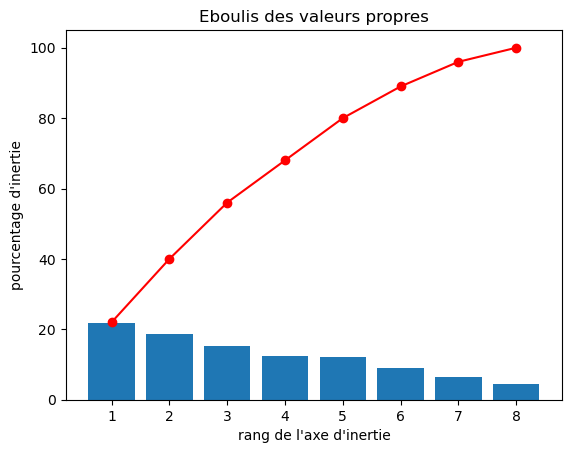

In [98]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

On voit ici que environ 40% de la variance est comprise dans les 2 premières composantes, et près de 80% dans les 6 premières.

In [99]:
pcs = pca.components_
pcs

array([[-1.62947564e-01,  3.15279489e-01,  1.25295348e-02,
         3.93054581e-03,  9.65840202e-02, -6.42828184e-01,
        -6.48766127e-01,  1.74414627e-01],
       [-1.26389121e-02, -3.70496422e-02,  7.06319644e-01,
         7.06423138e-01, -2.25274737e-02, -4.45028778e-03,
         4.32886140e-03,  6.79240239e-04],
       [ 6.29190201e-01,  6.03997367e-01,  2.74311688e-02,
         3.02780860e-02,  4.21926831e-01,  2.24928195e-01,
         1.68251886e-03,  9.49729709e-02],
       [ 3.95972115e-01,  3.72388604e-02, -2.04490169e-02,
         5.57412632e-03, -7.85798244e-01,  8.60371107e-02,
        -1.67223691e-01,  4.34194762e-01],
       [-3.10591655e-01, -4.93346959e-02, -4.26299740e-03,
         3.54385901e-03,  2.83800883e-01,  9.98514417e-02,
         2.31208565e-01,  8.70113514e-01],
       [ 5.37495491e-01, -7.15545799e-01,  5.15974548e-03,
        -2.33792268e-02,  3.17435399e-01, -2.24979433e-01,
        -1.79931136e-01,  1.21504747e-01],
       [-5.25297044e-03,  1.254023

In [100]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,-0.162948,0.315279,0.012530,0.003931,0.096584,-0.642828,-0.648766,0.174415
1,-0.012639,-0.037050,0.706320,0.706423,-0.022527,-0.004450,0.004329,0.000679
2,0.629190,0.603997,0.027431,0.030278,0.421927,0.224928,0.001683,0.094973
3,0.395972,0.037239,-0.020449,0.005574,-0.785798,0.086037,-0.167224,0.434195
4,-0.310592,-0.049335,-0.004263,0.003544,0.283801,0.099851,0.231209,0.870114
5,0.537495,-0.715546,0.005160,-0.023379,0.317435,-0.224979,-0.179931,0.121505
6,-0.005253,0.012540,0.706882,-0.706653,-0.017689,0.019180,-0.002335,0.009366
7,0.187664,0.135756,0.007580,-0.009240,-0.114201,-0.683961,0.682114,0.009245


In [101]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
F1,-0.16,0.32,0.01,0.00,0.10,-0.64,-0.65,0.17
F2,-0.01,-0.04,0.71,0.71,-0.02,-0.00,0.00,0.00
F3,0.63,0.60,0.03,0.03,0.42,0.22,0.00,0.09
F4,0.40,0.04,-0.02,0.01,-0.79,0.09,-0.17,0.43
F5,-0.31,-0.05,-0.00,0.00,0.28,0.10,0.23,0.87
F6,0.54,-0.72,0.01,-0.02,0.32,-0.22,-0.18,0.12
F7,-0.01,0.01,0.71,-0.71,-0.02,0.02,-0.00,0.01
F8,0.19,0.14,0.01,-0.01,-0.11,-0.68,0.68,0.01


In [102]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
fiber_100g,-0.162948,-0.012639,0.629190,0.395972,-0.310592,0.537495,-0.005253,0.187664
proteins_100g,0.315279,-0.037050,0.603997,0.037239,-0.049335,-0.715546,0.012540,0.135756
vitamin-a_100g,0.012530,0.706320,0.027431,-0.020449,-0.004263,0.005160,0.706882,0.007580
vitamin-c_100g,0.003931,0.706423,0.030278,0.005574,0.003544,-0.023379,-0.706653,-0.009240
fat_100g,0.096584,-0.022527,0.421927,-0.785798,0.283801,0.317435,-0.017689,-0.114201
carbohydrates_100g,-0.642828,-0.004450,0.224928,0.086037,0.099851,-0.224979,0.019180,-0.683961
sugars_100g,-0.648766,0.004329,0.001683,-0.167224,0.231209,-0.179931,-0.002335,0.682114
sodium_100g,0.174415,0.000679,0.094973,0.434195,0.870114,0.121505,0.009366,0.009245


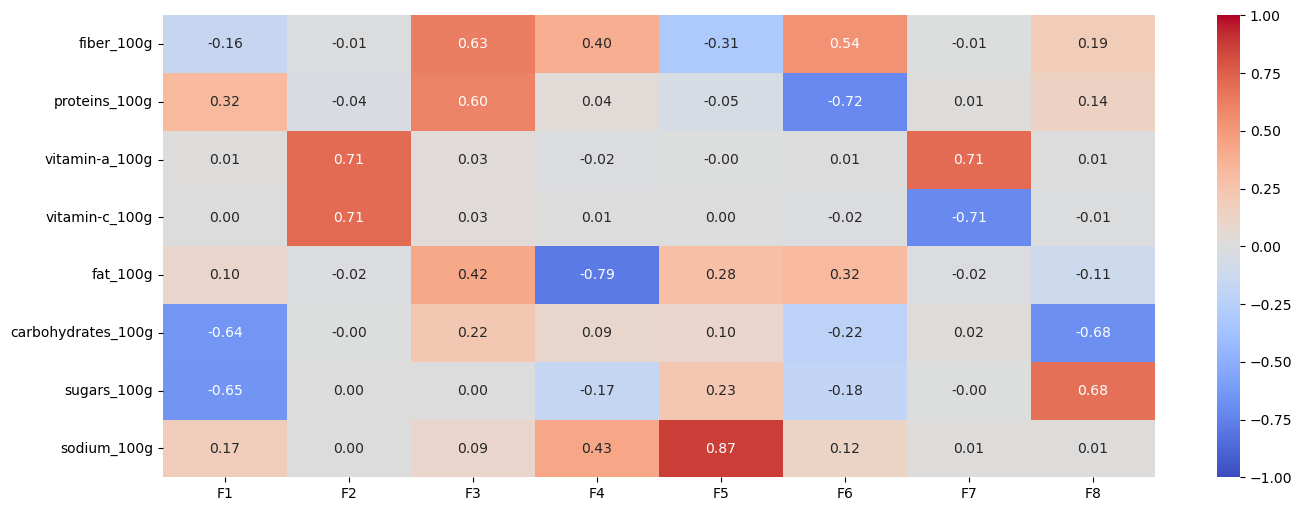

In [103]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

Graphe de correlation 

In [104]:
x, y = 0,1

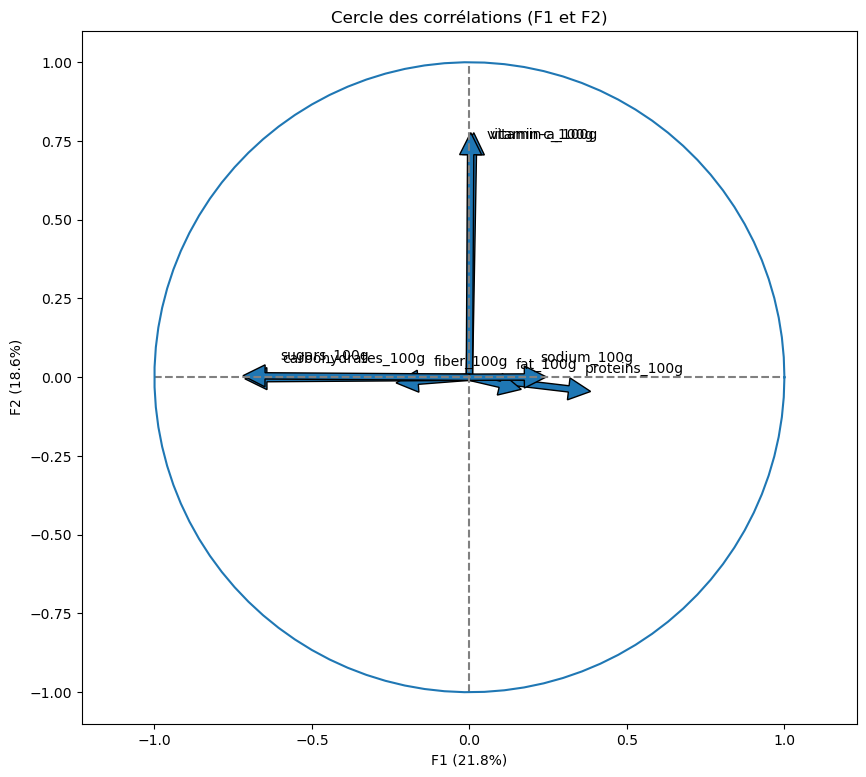

In [105]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0, 
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

- Créeons la fonction de correlation 

In [106]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
   
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Pour F1 et F2 il faut bien préciser  0 et 1  

In [107]:
x_y = (0,1)
x_y

(0, 1)

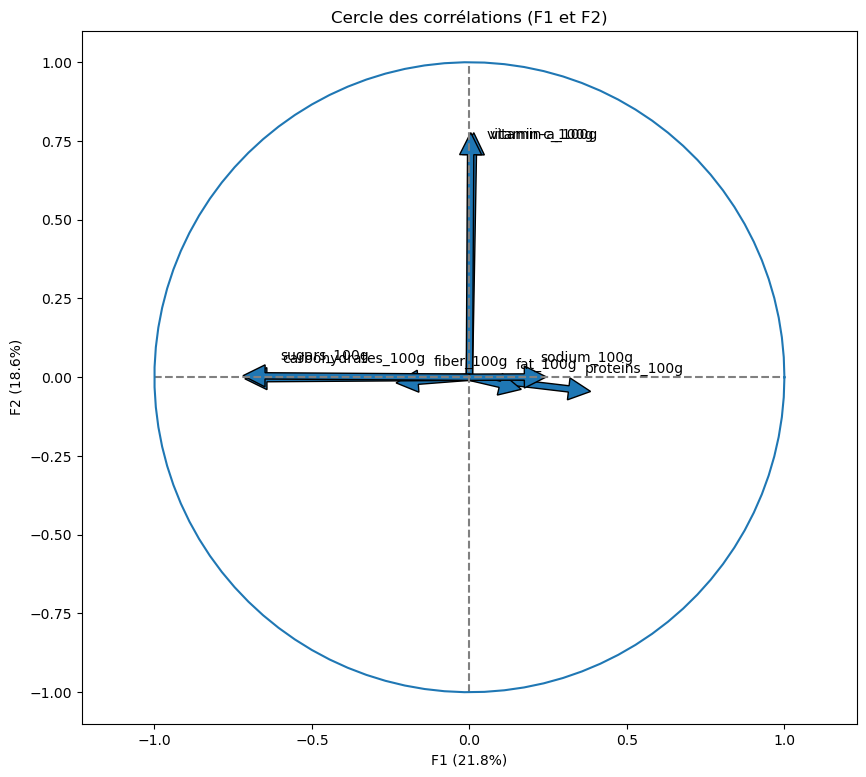

In [108]:
correlation_graph(pca, x_y, features)

Essayons pour F3 et F4 : 

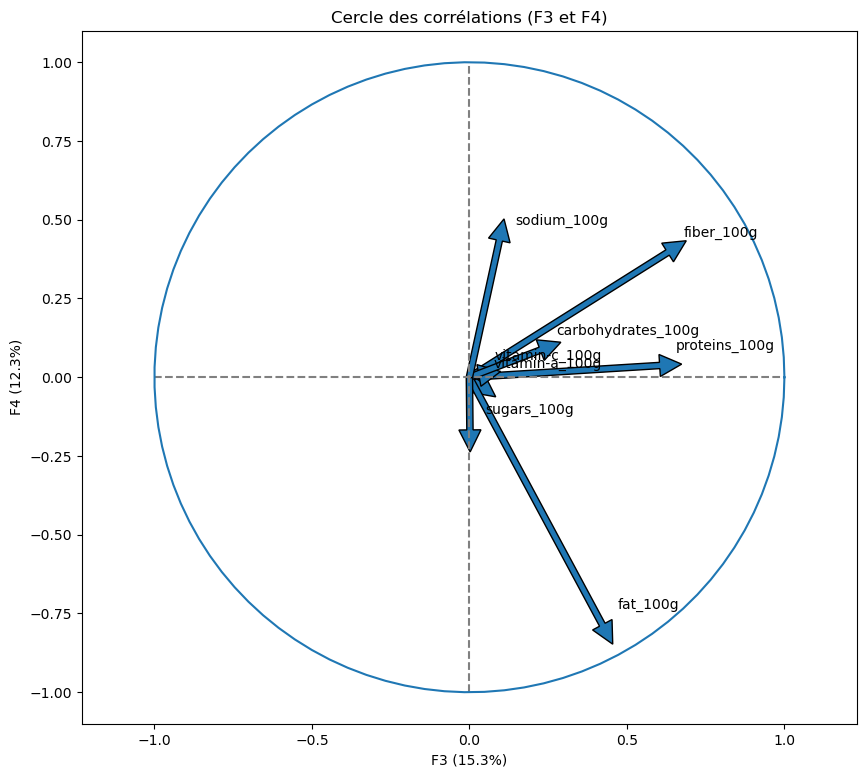

In [109]:
correlation_graph(pca, (2,3), features)

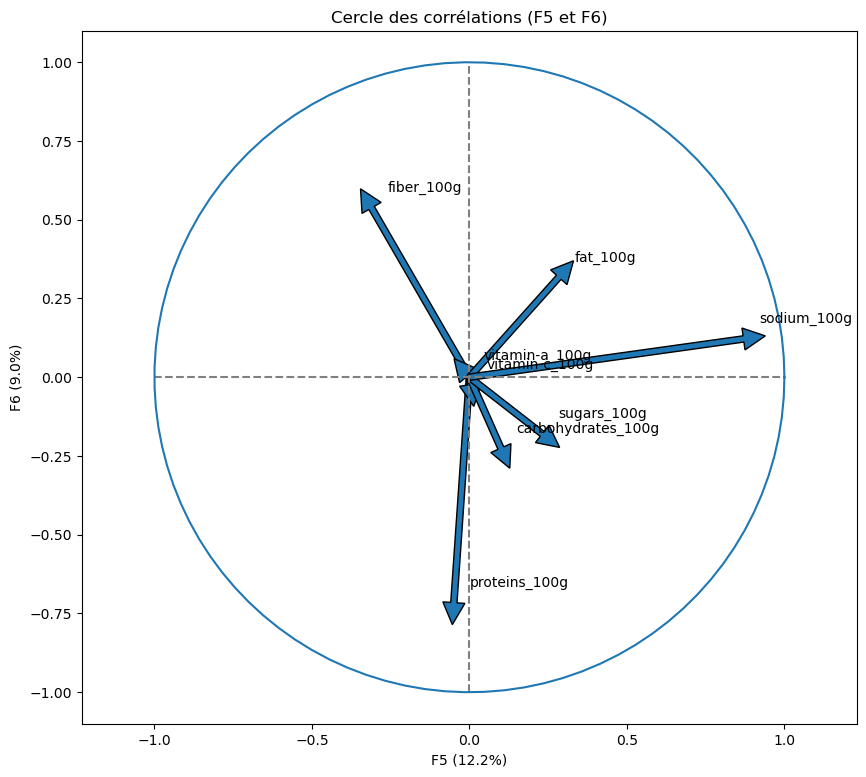

In [110]:
correlation_graph(pca, (4,5), features)

Projection

In [111]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-0.3474239 , -0.10490277,  3.32954883,  0.62742697, -1.28541197,
         2.97748675, -0.04980685,  0.04431401],
       [ 1.10024394,  0.70112006, -0.0244119 , -2.22102007,  0.59024421,
         1.5442602 ,  0.65896419, -0.28535362],
       [-3.44157079,  0.02382373, -0.3687385 ,  0.01971832,  0.60734019,
        -1.18939076,  0.03695434,  0.71800479],
       [-0.55698777,  0.00639906, -0.55629679, -0.48703993,  0.17651615,
        -0.05361004, -0.00976427,  0.22652458],
       [ 1.01380157, -0.01281666, -0.49284656, -0.12500992, -0.31628932,
        -0.19827393, -0.01214691,  0.21117688]])

In [112]:
x_y

(0, 1)

In [113]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):   

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)  
    if not figsize: 
        figsize = (7,6)
    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e
    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   
    x, y = x_y
    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters     
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c) 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1  
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)  
    if len(labels) :       
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')  
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

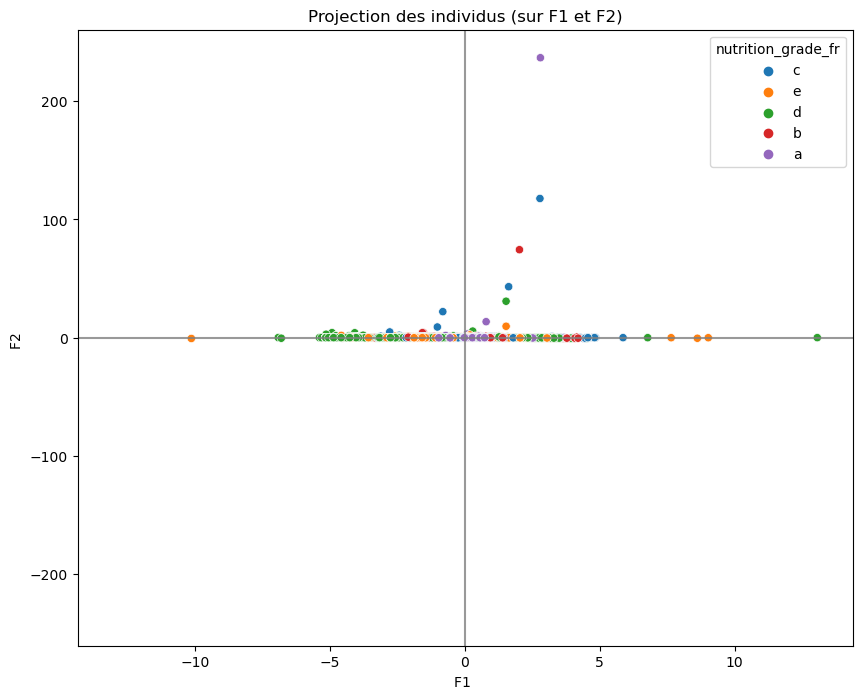

In [114]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=jeu0_C['nutrition_grade_fr'])

La version plus *élaborée* avec F1 et F2 

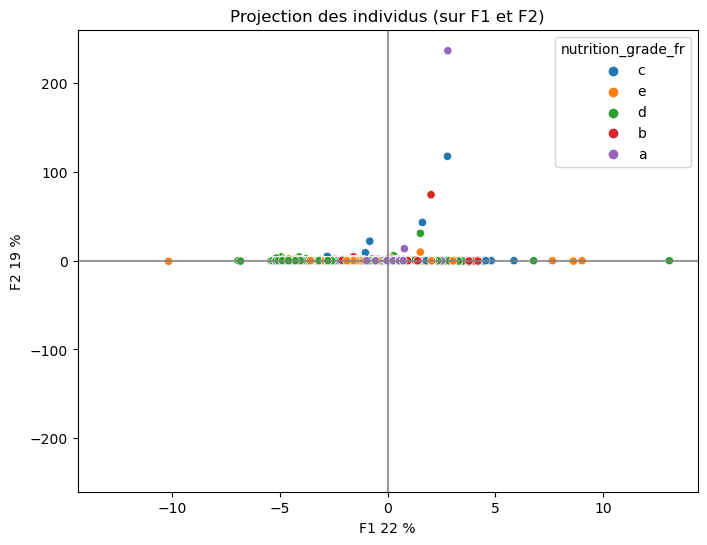

In [115]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca,  figsize=(8,6), clusters=jeu0_C['nutrition_grade_fr'], marker="o")

Essayons avec F2 et F3

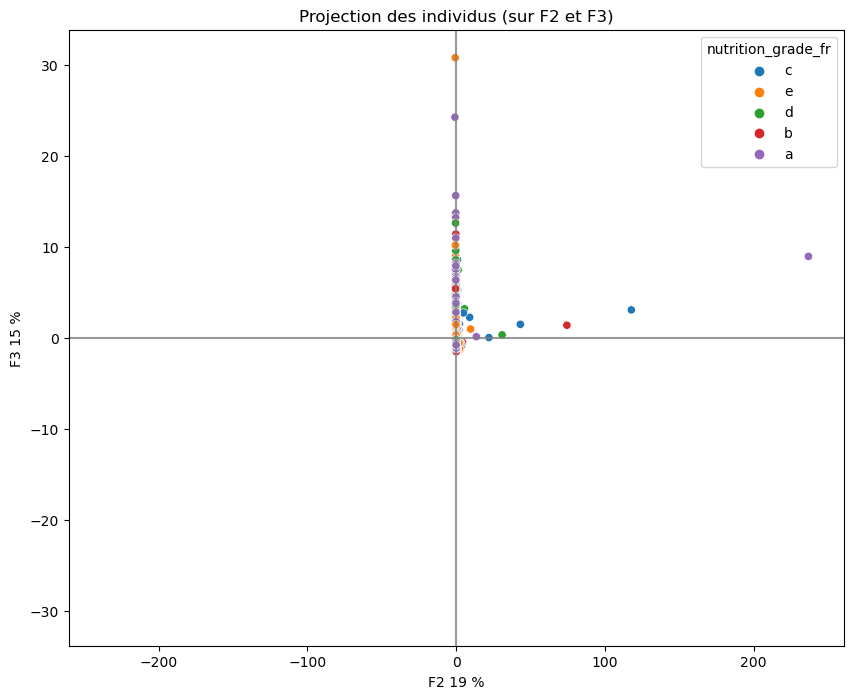

In [116]:
x_y = 1,2
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

Essayons avec F3 et F4

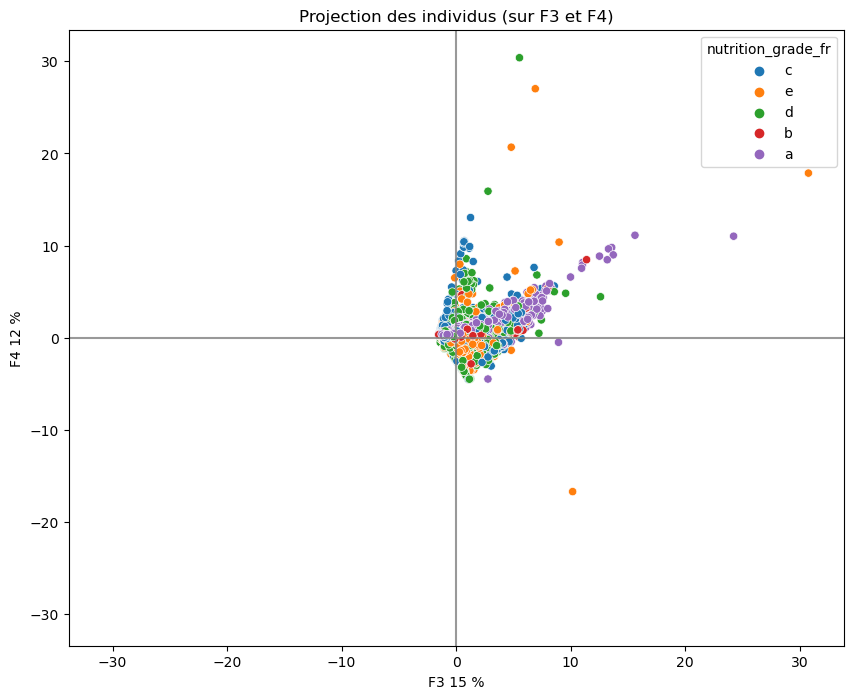

In [117]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

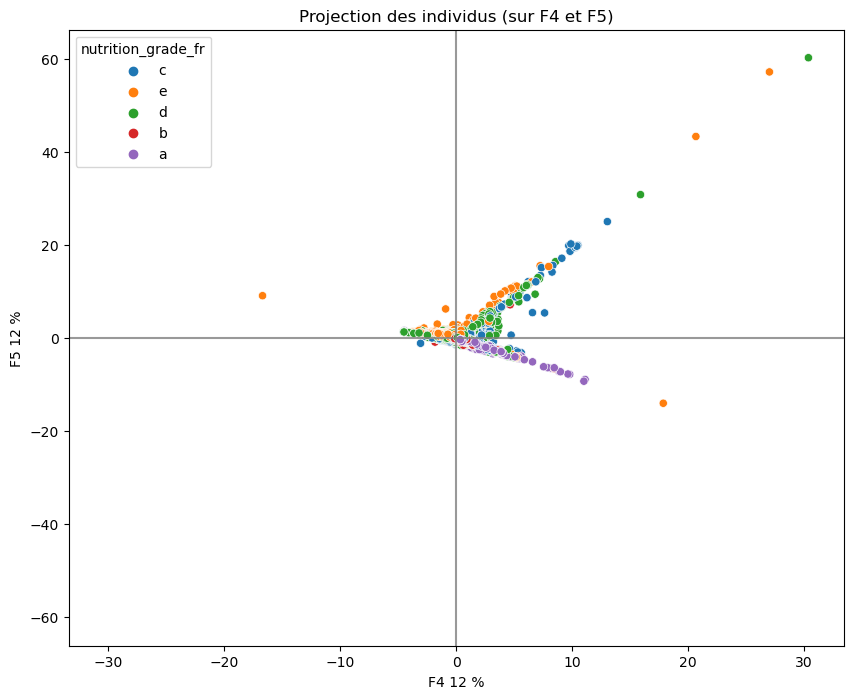

In [118]:
x_y = 3,4
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

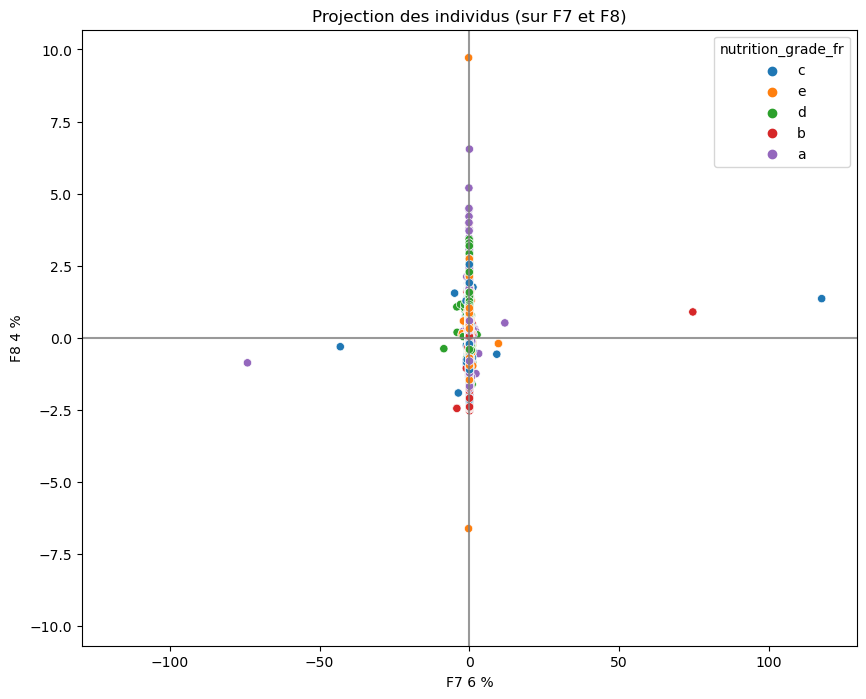

In [119]:
x_y = 6,7
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

## Conclusion

Durant l'analyse du jeu de données associé au projet, le constat est que la plupart des features ne sont pas rempli(quasiment vide), sur les 162 features c'est a peine si on peut exploiter 45 veritablement. je me pose la question sur la necessite réelle de leur existance.

- La RGPD signifie « Règlement Général sur la Protection des Données » Ce Règlement encadre le traitement des données personnelles sur le territoire de l'Union européenne.
#### Le principe de finalité.
le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
#### Le principe de proportionnalité et de pertinence.
les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
#### Le principe d'une durée de conservation limitée. 
il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
#### Le principe de sécurité et de confidentialité. 
le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
#### Les droits des personnes.

Malgré que nos données ne concernent pas des personnes, nous devons veiller à la fiabilité des informations que nous publions etant donné que cela concerne le domaine de la santé. Une erreur peux avoir de graves conséquences. Supposons qu'il est enregistré qu'un produit contient 60g de graisse pour 100g alors qu'en réalité sa contenance est de 60g pour 100g. Cela peut avoir des consecances non negligeable sur la santé.